In [2]:
import numpy as np
import pandas as pd
import torch
import torchvision
import matplotlib.pyplot as plt

from pytorch_lightning import LightningModule, Trainer
import torchvision.models as models
#from pl_bolts.callbacks import ORTCallback
import torchmetrics

import dataset_tools


print('CUDA available:', torch.cuda.is_available())

CUDA available: True


# ⬇️ Data

In [6]:
ROOT_DIR = '/tcmldrive/databases/Public/TCGA/data/'
TRAIN_DIR = ROOT_DIR + 'train'
TEST_DIR = ROOT_DIR + 'test'

class params:
    num_workers = 24
    bs = 256

### Transforms
# rgb_mean = (0.4914, 0.4822, 0.4465)
# rgb_std = (0.2023, 0.1994, 0.2010)
train_tfms = torchvision.transforms.Compose([
    # torchvision.transforms.RandomCrop(32, padding=4),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    # torchvision.transforms.Normalize(rgb_mean, rgb_std),
])
test_tfms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    # torchvision.transforms.Normalize(rgb_mean, rgb_std),
])

### Datasets
train_ds = dataset_tools.ImageFolderWithPaths(TRAIN_DIR, train_tfms)
test_ds = dataset_tools.ImageFolderWithPaths(TEST_DIR, test_tfms)

### Dataloaders
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=params.bs, num_workers=params.num_workers, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=params.bs, num_workers=params.num_workers, shuffle=False)

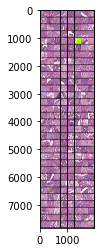

In [7]:
images = next(iter(train_dl))[1]
plt.imshow(torchvision.utils.make_grid(images, padding=20).permute(1, 2, 0))

# Model

In [18]:
class VisionModel(LightningModule):
    def __init__(self):
        super().__init__()
        self.model = models.resnet18(pretrained=True)
        self.criteria = torch.nn.CrossEntropyLoss()
        
        self.train_patient_level_df = data_tools.train_data_dataframe()
        self.test_patient_level_df = data_tools.test_data_dataframe()
        
    def forward(self, x):
        return self.model(x)
        
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        
        loss = self.criteria(logits, y)
        acc = torchmetrics.functional.accuracy(logits.softmax(dim=-1), y)
        
        self.log('train_loss', loss)
        self.log('train_acc', acc)
        loss = loss.unsqueeze(dim=-1)
        return {"loss": loss, "acc": acc}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        
        val_loss = self.criteria(logits, y)
        val_acc = torchmetrics.functional.accuracy(logits.softmax(dim=-1), y)
        
        self.log('val_loss', val_loss)
        self.log('val_acc', val_acc)
        val_loss = val_loss.unsqueeze(dim=-1)
        return {"val_loss": val_loss, "val_acc": val_acc}
    # def train_dataloader():
        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)
    
    def on_epoch_end(self):
        # evaluate on training and testing
        train_score = 0
        
        for r in self.test_patient_level_df.iterrows():
            print(r)
        

In [19]:
model = VisionModel()
trainer = Trainer(gpus=0, max_epochs=30)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [20]:
model.on_epoch_end()

(0, patient_id                                         TCGA-G4-6309
class                                                    MSIMUT
filenames     [/tcmldrive/databases/Public/TCGA/data/test/MS...
Name: 0, dtype: object)
(1, patient_id                                         TCGA-AZ-6601
class                                                    MSIMUT
filenames     [/tcmldrive/databases/Public/TCGA/data/test/MS...
Name: 1, dtype: object)
(2, patient_id                                         TCGA-CK-6747
class                                                    MSIMUT
filenames     [/tcmldrive/databases/Public/TCGA/data/test/MS...
Name: 2, dtype: object)
(3, patient_id                                         TCGA-AZ-4615
class                                                    MSIMUT
filenames     [/tcmldrive/databases/Public/TCGA/data/test/MS...
Name: 3, dtype: object)
(4, patient_id                                         TCGA-CM-4743
class                                               

In [ ]:
#IN TRAINER: , callbacks=ORTCallback()
trainer.fit(model, train_dataloader=train_dl, val_dataloaders=test_dl)

In [ ]:
!jupyter notebook stop 8888